In [32]:
#default_exp core.random_variable

- [X] TODO: implement kde estimation and entropy estimation
- [X] TODO: make an abstracction for random varriable in order to bring kde to same abstractions of sample, etc...
- [X] TODO: consider using awkde os scipy for small samples dataset (< 400)
- [ ] TODO: make an abstracction for random varriable in order to bring sklearn GMM and kde  to same abstractions of sample, etc...
- [ ] TODO: make RVArray an instance of np.array
- [ ] TODO: make RVarray access attributes for multidimensional RVarrays and return array with same size of result objects

In [8]:
#hide
from nbdev.showdoc import *

In [9]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Meta Distributions

> Extension of SciPy rv_continuous Class, containing some useful methods for Maximum Likelihood Estimation and other distribution methods.

## imports

In [10]:
#export
from functools import partial
from warnings import warn

import scipy
import scipy.stats as stats
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA, KernelPCA

import KDEpy as kdepy
import awkde

from skdensity.utils import (
    cos_sim_query, sample_multi_dim, ctqdm, DelegateEstimatorMixIn, _vector_1d_to_matrix,_assert_dim_3d,_assert_dim_2d,
    add_noise
)

## KDE Class - 

In [11]:
#export

#Identity transformer in case space_transformer is None
def identity_func(x):
    return x

IDENTITY_TRANSFORMER = FunctionTransformer(
    func = identity_func,
    inverse_func = identity_func,
    validate=False,
    accept_sparse=True,
    check_inverse=True,
    kw_args=None,
    inv_kw_args=None,
)

def agg_smallest_distance(data, agg_func = np.mean):
    '''
    returns the agregate (defined by agg_func) distance of each point and their closest neighbor
    recieves array of shape (n_dists,n_samples, n_dims) and reutrns array of shape (n_dists, n_dims)
    '''
    _assert_dim_3d(data)
    data = np.sort(data, axis = 1)
    diff = np.diff(data, axis = 1)
    results = agg_func(diff, axis = 1)    
    return results

class KDE():
    
    AVALIBLE_BW_METHODS = ['ISJ', 'scott', 'silverman', 'mean_distance', 'std_distance', 'median_distance']
    
    def __init__(self, bw = 'std_distance', space_transformer = PCA, implementation = 'sklearn', st_kws = {}, **kde_kws):        
        
        if bw.__class__ == str:            
            assert bw in self.AVALIBLE_BW_METHODS, f"if str, bw should be one of {self.AVALIBLE_BW_METHODS}, not {bw}"
        if not isinstance(bw,(str, float, np.float64, np.float32, np.float)):
            raise TypeError(f'bw should be str or float, not {bw.__class__}')
        self.bw = bw
        self._space_transformer = space_transformer if not space_transformer is None else IDENTITY_TRANSFORMER
        self.kde_kws = kde_kws
        self.st_kws = st_kws
        if not implementation in ['scipy','sklearn','awkde']:
            raise ValueError(f'implementation should be one of ["sklearn","scipy","awkde"], not {implementation}')
        
        self.implementation = implementation
                        
    def _check_X_2d(self,X):
        X = np.array(X)
        #reshape if shape == (n_samples,)
        X = X if len(X.shape) > 1 else X.reshape(-1,1)
        return X
    
    def _check_input_dims_match(self, X):
        if X.shape[-1] != self.n_dim:
            raise ValueError(f'X dimensions space should be the same size as fitted distribution ({self.n_dim}), got {X.shape[-1]} instead')                
        
    def _get_bw_each_dim(self, X, bw_method):
        if bw_method in ['ISJ', 'scott', 'silverman']:
            return np.array([kdepy.FFTKDE(bw = bw_method).bw(X[:,i:i+1]) for i in range(X.shape[-1])])
        elif bw_method == 'mean_distance':
            return np.array([agg_smallest_distance(X[:,i].reshape(1,X.shape[0],1), np.mean) for i in range(X.shape[-1])])
        elif bw_method == 'median_distance':
            return np.array([agg_smallest_distance(X[:,i].reshape(1,X.shape[0],1), np.median) for i in range(X.shape[-1])])
        elif bw_method == 'std_distance':
            return np.array([agg_smallest_distance(X[:,i].reshape(1,X.shape[0],1), np.std) for i in range(X.shape[-1])])
    
    def _preprocess_fit(self, X):
        '''
        preprocess data prior to fit. ensure len >2 and add some white noise to avoid eigenvalues errors in space transform
        '''
        X = self._check_X_2d(X)
        if len(X) < 2:
            X = np.concatenate([X,X])
        X = add_noise(X, 1e-9)
        return X
        
    def fit(self, X, y = None, sample_weight = None):                                        
        #preprocess X
        X = self._preprocess_fit(X)            
        #fit and transform X with manifold learner (self.space_transformer)
        if isinstance(self._space_transformer, type):
            self._space_transformer = self._space_transformer(**{**self.st_kws, **{
                'n_components':X.shape[-1], 'whiten':True}})
        
        X = self._space_transformer.fit_transform(X)        
        # calculate bw
        if self.bw.__class__ == str:
            bw = self._get_bw_each_dim(X, self.bw)            
            bw = np.sqrt(np.sum(bw**2))
        else:
            warn('passing a float value for bw is not recomended since X will be transformed by space_transformer before fitting and bw value may not make sence in new trnasformed space')
            bw = self.bw
        
        #ensure bw is positive
        bw = max(1e-4, bw)
        #kde
        if self.implementation == 'sklearn':
            self.estimator = KernelDensity(**{**{'bandwidth':bw},**self.kde_kws}).fit(X, y, sample_weight = sample_weight)            
        elif self.implementation == 'scipy':
            self.estimator = stats.gaussian_kde(X.T, bw_method = bw)
        elif self.implementation == 'awkde':
            self.estimator = awkde.GaussianKDE(**{**{'glob_bw':bw},**self.kde_kws})
            self.estimator.fit(X = X, weights = sample_weight)
        else: raise ValueError(f'self.implementation should be one of ["sklearn","scipy","awkde"], not {self.implementation}')
                
        self._transformed_bw_value = bw
        self.n_dim = X.shape[-1]
        return self
    
    def evaluate(self, data):
        data = self._check_X_2d(data)        
        #transform input
        data = self._space_transformer.transform(data)
        self._check_input_dims_match(data)
        #get likelihoods
        if self.implementation == 'sklearn':        
            likelihood = np.exp(self.estimator.score_samples(data))
        elif self.implementation == 'scipy':
            likelihood = self.estimator.pdf(data.T)
        elif self.implementation == 'awkde':        
            likelihood = self.estimator.predict(data)
        else: raise ValueError(f'self.implementation should be one of ["sklearn","scipy","awkde"], not {self.implementation}')
        
        return likelihood
        
    def predict(self, X):        
        return self.evaluate(X)
    
    def pdf(self, data):        
        return self.evaluate(data)
    
    def rvs(self, size = 1, random_state = None):
        sample_size = size
        if self.implementation == 'sklearn':
            samples = self.estimator.sample(n_samples = sample_size, random_state = random_state)
        elif self.implementation == 'scipy':
            samples = self.estimator.resample(sample_size, random_state).T
        elif self.implementation == 'awkde':
            samples = self.estimator.sample(n_samples = sample_size, random_state = random_state)
        else: raise ValueError(f'self.implementation should be one of ["sklearn","scipy","awkde"], not {self.implementation}')
        #inverse transform samples
        samples = self._space_transformer.inverse_transform(samples)
        return samples        
    
    def sample(self, sample_size = 1, random_state = None):
        return self.rvs(sample_size, random_state)
    
    def entropy(self, sample_size = 100):        
        return np.mean(-np.log2(self.evaluate(self.rvs(size = sample_size))))                    
        
    def cdf(self, data, sample_size = 100):                
        #estimate using sampling and QuantileTransformer since integration is too costly
        samples = self.sample(sample_size = sample_size)
        return QuantileTransformer(n_quantiles = min(1000,samples.shape[0])).fit(samples).transform(data)
        
    def ppf(self, data, sample_size = 100):
        #estimate using sampling and QuantileTransformer since integration is too costly
        data = np.array(data)
        assert (data.min() >= 0) and (data.max() <= 1), 'data contains values < 0 or > 1'
        samples = self.sample(sample_size = sample_size)
        return QuantileTransformer(n_quantiles = min(1000,samples.shape[0])).fit(samples).inverse_transform(data)
    
    def _make_conditioning_grid(self, condition_dict = {}, resolution = None):        
        samples, likelihood = self.sample(1000) #estimate min and max intervals 
        argsrt = np.argsort(likelihood)[::-1]
        likelihood_msk = likelihood[argsrt].cumsum() < 0.99*likelihood.sum()
        likelihood_msk = argsrt[likelihood_msk]
        #ignore points with low likelihood
        grid_min, grid_max = samples[likelihood_msk].min(axis = 0), samples[likelihood_msk].max(axis = 0)
        dim_grid = []
        for dim in range(grid_min.shape[0]):
            dim_min, dim_max = grid_min[dim], grid_max[dim]
            if not dim in condition_dict:
                dim_grid.append(np.linspace(dim_min,dim_max, resolution))
            else:
                dim_grid.append(np.linspace(condition_dict[dim],condition_dict[dim], resolution))
        return np.array(dim_grid).T


Testing with moons

In [12]:
from sklearn.datasets import make_moons
import seaborn as sns 
import matplotlib.pyplot as plt
def rotate(x, degree):
    theta = np.radians(degree)
    r = np.array(( (np.cos(theta), -np.sin(theta)),
                   (np.sin(theta),  np.cos(theta)) ))
    return x.dot(r)

moon1, ds1 = make_moons(n_samples = 2000, noise = .1)
moon2, ds2 = make_moons(n_samples = 2000, noise = .1) 
moon1 = rotate(moon1, 90)+.5
moon2 = rotate(moon2, 15)
moons = np.concatenate([moon1,moon2])
#sns.jointplot(moons[:,0], moons[:,1])

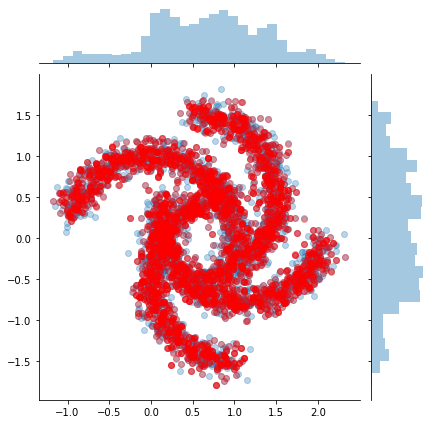

In [181]:
kde = KDE(implementation = 'scipy', bw = 'mean_distance', space_transformer= KernelPCA(n_components = 2, kernel = 'linear', fit_inverse_transform = True))
kde.fit(moons)
kde.evaluate(moons)
samples = kde.sample(4000)
jnt = sns.jointplot(moons[:,0], moons[:,1], alpha = 0.3)
jnt.ax_joint.scatter(samples[:,0], samples[:,1], color = 'r', alpha = 0.3)

4.3 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
46.5 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


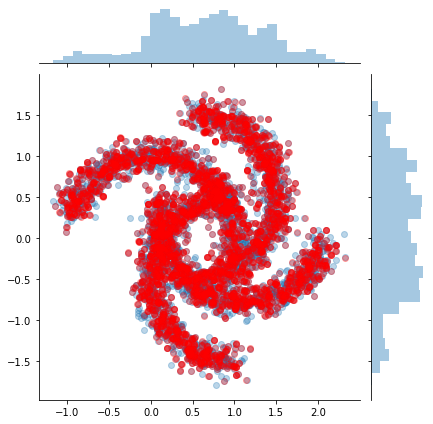

In [182]:
kde = KDE(implementation = 'sklearn', bw = 'std_distance', rtol = 0.01)
%timeit kde.fit(moons)
%timeit kde.evaluate(moons)
samples = kde.sample(4000)
jnt = sns.jointplot(moons[:,0], moons[:,1], alpha = 0.3)
jnt.ax_joint.scatter(samples[:,0], samples[:,1], color = 'r', alpha = 0.3)

19.4 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
762 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


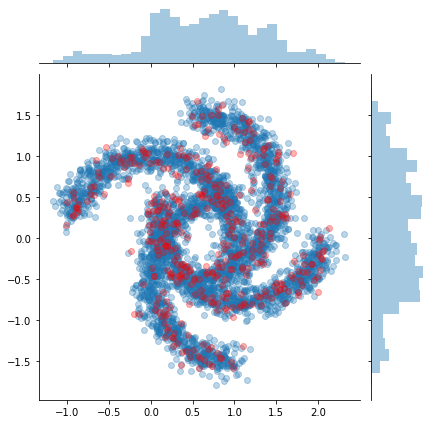

In [183]:
kde = KDE(implementation = 'sklearn', bw = 'ISJ')
%timeit kde.fit(moons)
%timeit kde.evaluate(moons)
samples = kde.sample(400)
jnt = sns.jointplot(moons[:,0], moons[:,1], alpha = 0.3)
jnt.ax_joint.scatter(samples[:,0], samples[:,1], color = 'r', alpha = 0.3)

## RandomVariable Class - 

In [67]:
#export


#CREATE EMPIRICAL DIST METHODS (WITH ADD NOISE IN SAMPLING OPTION AND ALL) <-----
class RandomVariable():
    '''
    A container for distribution objects
    '''
    
    def __init__(self, default_dist = 'kde', verbose = False, keep_samples = False):        
        self._fitted_dists = {}
        self.log_likelihood = []
        self.default_dist = default_dist
        self.verbose = verbose
        self.keep_samples = keep_samples
        self._samples = None
        return
        
    def _reset_fits(self,):
        self._fitted_dists = {}
        self.log_likelihood = []
        self._samples = None
        
    def __getitem__(self, item):
        if item == 'best':
            try:
                item = self._best_fit_alias
            except AttributeError:
                raise AttributeError('RandomVariable object has no "best" fit yet. Fit at least one density function through fit_dist method')
        
        return self._fitted_dists[item][0]
    
    #def __repr__(self):
    #    return f'RandomVariable({str(self.samples)})'        
    
    def _fit_ecdf(self, data, **ecdf_kwargs):
        self.ecdf = QuantileTransformer(**ecdf_kwargs).fit(data)
        return self
        
    def fit_new(self, data, dist = None, **dist_kwargs):
        '''
        fits given distributions
        creates alias `best` for dist with maximum likelihood
        '''        
        if dist is None:
            dist = self.default_dist
        
        if dist.__class__ in [list,tuple,set]:
            pass
        elif dist.__class__ == str:
            dist = [dist]
        else:
            raise TypeError(f'dist should be str, list, tuple or set, not {dist.__class__}')
        
        self.n_dim = 1 if len(data.shape) == 1 else data.shape[-1]
        if self.keep_samples:
            self._samples = data
        
        self._fit_all(data ,dist, **dist_kwargs)
        
        return self
    
    def fit(self, data, dist = None, **dist_kwargs):
        self._reset_fits()
        self.fit_new(data, dist, **dist_kwargs)
        return self
    
    def _check_best(self):
        dists_aliases = list(self._fitted_dists)
        dists_arr = np.array([i[1] for i in self._fitted_dists.values()])
        best_fit_idx = np.argmax(dists_arr)
        self._best_fit_alias = dists_aliases[best_fit_idx]
        return
    
    def _fit_all(self, data, dists):        
        #TODO: check for multiplicity in candidates aliases
        for candidate in ctqdm(dists, verbose = self.verbose):
            self._fit_dist(data, candidate)            
        return self

    def _fit_dist(self, data, dist, **dist_kwargs):      
        '''
        fits a specified distribution through scipy.stats.rv_continuous.fit method
        '''
        alias, dist_name = self._handle_dist_names(dist)
        alias, dist_class = self._get_dist_from_name(alias, dist_name)
        if alias.lower() == 'best':
            raise ValueError('"best" cannot be an alias for a distribution. its internally assgined to the best fit dist')
        
        if alias == 'rv_histogram':
            hist = np.histogram(data, bins = 'auto')#len(np.unique(data)))
            dist = dist_class(hist)
            log_likelihood = np.sum(np.log(dist.pdf(data)))
            self._fitted_dists = {**self._fitted_dists, **{alias:(dist,log_likelihood)}}
            self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
            
        elif alias != 'kde':
            if self.n_dim > 1:
                raise ValueError('rv_continuous distributions is only available for 1d distributions. Use "kde" dist instead.')
            params = dist_class.fit(data)
            log_likelihood = np.sum(np.log(dist_class.pdf(data,*params)))
            self._fitted_dists = {**self._fitted_dists, **{alias:(dist_class(*params),log_likelihood)}}
            self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
        else:
            dist = dist_class(**dist_kwargs).fit(data)
            log_likelihood = np.sum(np.log(dist.pdf(data)))
            self._fitted_dists = {**self._fitted_dists, **{alias:(dist,log_likelihood)}}
            self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
        
        #update 'best' alias
        self._check_best()
        return self
    
    
    def _get_dist_from_name(self, alias, dist_name):
        '''
        handles dist_names. if str tries to get an attribute from scipy.stats accordingly
        that is also instance of scipy.stats.rv_continuous
        '''
        if isinstance(dist_name,str):        
            if dist_name.lower() == 'kde':
                alias = 'kde'
                return (alias, KDE)
            
            elif dist_name in dir(stats):
                alias = dist_name
                return (alias, getattr(stats,dist_name))
            
            else:
                raise ValueError(f'dist must be a valid scipy.stats.rv_continuous subclass, not {getattr(stats,dist_name)}')

        elif isinstance(dist_name, stats.rv_continuous):
            return (alias, dist_name)
        else:
            raise ValueError(f'dist must be a valid scipy.stats.rv_continuous subclass or str, not {dist_name}')
    
    def _handle_dist_names(self, candidate_value):
        '''
        checks the inputs in elements of "candidates"
        returns a named tuple
        '''
        if isinstance(candidate_value, str):
            return candidate_value, candidate_value

        elif isinstance(candidate_value, tuple):

            if not len(candidate_value) == 2:
                raise ValueError(f'candidate named tuple must be of size 2, "{candidate_value}" has size {len(candidate_value)}')

            if not isinstance(candidate_value[0], str):
                raise ValueError(f'a candidate must be a str or named tuple (alias[str],<rv_continuous intance>), alias is of type {candidate_value[0].__class__}')

            else:
                return candidate_value                
    
    def sample(self, sample_size, dist = 'best', **kwargs):        
        return self.rvs(size = sample_size, dist = dist, **kwargs)
    
    def rvs(self, size, dist = 'best', **kwargs):        
        samples = self[dist].rvs(size = size, **kwargs)
        
        if len(samples.shape) == 1:
            samples = samples.reshape(*samples.shape,1)
        
        return samples
    
    def _fix_inference_data_input(self, data):
        if len(data.shape) == 1:
            data = data.reshape(-1,1)
        _assert_dim_2d(data)
        assert data.shape[1] == self.n_dim, f'Expected data to have shape (n_samples, n_dims({self.n_dim})). got (n_samples, n_dims({data.shape[1]})).'
        return data
    
    def _fix_inference_output(self, data):
        if len(data.shape) == 1:
            return data.reshape(-1,1)
        else:
            return data
        
    def cdf(self, data, dist = 'best', **cdf_kws):    
        data = self._fix_inference_data_input(data)
        samples = self[dist].cdf(data, **cdf_kws)
        return self._fix_inference_output(samples)
    
    def pdf(self, data, dist = 'best', **pdf_kws):        
        data = self._fix_inference_data_input(data)
        samples =  self[dist].pdf(data, **pdf_kws)
        return self._fix_inference_output(samples)
    
    def evaluate(self, data, dist = 'best', **evaluate_kws):    
        '''alias for self.pdf'''
        return self.pdf(data, dist = 'best', **evaluate_kws)
    
    def predict(self, data, dist = 'best', **predict_kws):
        '''alias for self.pdf'''
        return self.pdf(data, dist = 'best', **predict_kws)
    
    def ppf(self, data, dist = 'best', **ppf_kws):        
        data = self._fix_inference_data_input(data)
        samples = self[dist].ppf(data)
        return self._fix_inference_output(samples)
    
    def entropy(self, dist = 'best', **entropy_kws):
        return self[dist].entropy(**entropy_kws)
        

A RandomVariable Class facilitates the process of fitting multiple parametric distributions avalible in https://docs.scipy.org/doc/scipy/reference/stats.html from a data sample, for example:

Dist args:
(2, 2, 2)
[('norm', -1380.5104031844228), ('halfnorm', -1194.1891686012314), ('lognorm', -800.5206752923775)]
MLE fitted dist args:
lognorm


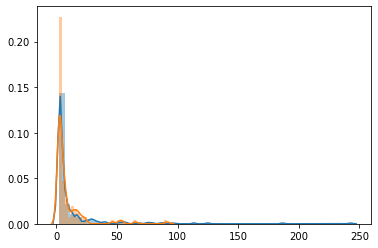

In [63]:
import seaborn as sns
dist_args = (2,2,2)

#data = stats.lognorm.rvs(dist_args[0], loc = dist_args[1], scale = dist_args[2], size = 30)
dist = stats.lognorm(s = dist_args[0],loc = dist_args[1], scale = dist_args[2])
data = dist.rvs(size = [300,1])
rv = RandomVariable()
rv.fit(data, dist = ['norm','halfnorm','lognorm'])

mle_samples = rv['best'].rvs([100,1])
#plot distributions

print('Dist args:')
print(dist_args)
print(rv.log_likelihood)
print('MLE fitted dist args:')
print(rv._best_fit_alias)

sns.distplot(data)
sns.distplot(mle_samples)


## RVArray - 

In [64]:
#export
#CREATE A CLASS THAT INHERITS FROM CustomArrayx called RVArray that implements method such as sample, pdf and others
#just to make sure the final user has access to correct documentation instead of generic __call__

#CREATE EMPIRICAL XXDIST CLASS (RV_HISTOGRAM IS TOO SLOW)

class CustomArray:
    '''
    An array that contains RandomVariable objects and facilitates method calls and getting attributes
    '''
    @property
    def data(self,):
        return self._data
    
    def __init__(self, data):
        ''' the constructor recieves a list of RandomVariable items'''
        self._data = np.array(data)
    
    def __getattr__(self, attr):
        attr_list = []
        for i in self.data:
            attr_list.append(getattr(i,attr))
        if all([callable(i) for i in attr_list]):
            return RVArray(attr_list)
        else:
            return np.array(attr_list)
    
    
    def __call__(self, *args, method = 'simple', **kwargs):
        '''
        method can be called in two ways:
        simple: the same args and kwargs are applied to all the objects inside RVArray
        broadcast: for each (row) object in RVArray, the correspondent (same row) arg and kwarg is applied
        '''
        assert method in ['simple','broadcast']
        
        if method == 'simple':
            results = []
            for i in self.data:            
                results.append(i(*args,**kwargs))

            if all([isinstance(i,np.ndarray) for i in results]):
                return np.array(results)
            else:
                return RVArray(results)
        
        elif method == 'broadcast':
            
            if args:
                args_lens_check = [len(arg) == len(self.data) for arg in args]
                assert all(args_lens_check)
            if kwargs:
                kwargs_lens_check = [len(arg) == len(self.data) for arg in kwargs.items()]            
                assert all(kwargs_lens_check)
            
            #prepare args
            if args:
                _args = []
                for arg in args:
                    _args.append([val for val in arg])            
                args = _args            
            #prepare kwargs
            _kwargs = []
            if kwargs:
                _len = len(kwargs[list(kwargs)[0]])
                for i in range(_len):
                    kwargs_i = {}
                    for key in kwargs:
                        kwargs_i[key] = kwargs[key][i]
                    _kwargs.append(kwargs_i)
                kwargs = _kwargs
            
            #run
            if kwargs and args:
                results = []
                for i in range(len(self.data)):            
                    results.append(self.data[i](*args[i],**kwargs[i]))
            
            elif kwargs and not args:
                results = []
                for i in range(len(self.data)):            
                    results.append(self.data[i](*args,**kwargs[i]))
            
            elif not kwargs and args:
                results = []
                for i in range(len(self.data)):
                    results.append(self.data[i](*[arg[i] for arg in args],**kwargs))
            else:
                results = []
                for i in range(len(self.data)):            
                    results.append(self.data[i](*args,**kwargs))
            
            #return values
            if all([isinstance(i,np.ndarray) for i in results]):
                return np.array(results)
            else:
                return RVArray(results)            
            
    
    def __getitem__(self, *args):

        if len(args) > 1:
            return RVArray(self.data[args])
        else:
            if args[0].__class__ == str:
                return RVArray([i[args[0]] for i in self.data])
            else:
                return self.data[args]      
    
    def __repr__(self):
        return f'RVArray({str(self.data)})'

A RVArray is a data sctructure tthat facilitates handling multiple RandomVariable objects, assessing RandomVariable methods and attributes in a vectorwise fashion

In [65]:
rv1 = RandomVariable(keep_samples = False).fit(np.hstack([mle_samples,mle_samples]))
rv2 = RandomVariable(keep_samples = True).fit(mle_samples)
rv_arr = RVArray([rv1,rv2]).fit(mle_samples, dist = 'rv_histogram')
#rv_arr.fit(mle_samples,'norm')
rv_arr.sample(10).shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log


(2, 10, 1)

In [54]:
#hide
# kde methods performance evaluation
from time import time
from tqdm import tqdm


n_samples = 400


dist = stats.norm(loc = 20, scale = 10)
tree_kde = [[],[]]
fft_kde = [[],[]]
adapatative_kde = [[],[]]
entropies = []
n_samples_list = []
for i in tqdm([*range(50)]):
    
    #samples = np.stack([dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),
    #               ], axis = -1)
    n_samples = int(max(2,10**(i/12)))
    n_samples_list.append(n_samples)
    samples = dist.rvs(n_samples)
    samples = samples if len(samples.shape) > 1 else samples.reshape(-1,1)
    
    bimodal_msk = np.random.randint(0,2,samples.shape[0]).astype(bool)

    samples[bimodal_msk] = -abs(samples[bimodal_msk])

    
    n_dim = samples.shape[-1]    
    resolution = int(10000**(1/n_dim))
    
    entropies.append(dist.entropy()*n_dim)
    if 0:#resolution**n_dim > 100000:
        tic = time()
        kde = kdepy.FFTKDE(bw = 'ISJ')
        bw = [kde.bw(samples[:,i:i+1]) for i in range(samples.shape[-1])]        
        kde = kdepy.TreeKDE(bw = bw).fit(samples)
        evaluate = kde.evaluate(samples)
        entr = np.mean(-np.log(evaluate[1]))
        toc = time()
        tree_kde[0].append(entr)
        tree_kde[1].append(toc-tic)
        #kde_values = evaluate[0]
        #kde_pdf = evaluate[1]
    if 1:           
        tic = time()
        kde = kdepy.FFTKDE(bw = 'scott')
        bw = [kde.bw(samples[:,i:i+1]) for i in range(samples.shape[-1])]
        kde = kdepy.FFTKDE(bw = bw).fit(samples)
        evaluate = kde.evaluate(resolution)
        #kde_values = evaluate[0]
        kde_pdf = evaluate[1]
        #idxs = euclidean_distances(kde.data,kde_values).argmin(axis = 1)
        #kde_pdf = kde_pdf[idxs]
        #kde_values = kde_values[idxs]
        kde_pdf = np.random.choice(kde_pdf,p = kde_pdf/kde_pdf.sum(), size = 1000)
        entr = np.mean(-np.log(kde_pdf))
        toc = time()
        fft_kde[0].append(entr)
        fft_kde[1].append(toc-tic)
    if 1:
        tic = time()
        g = awkde.GaussianKDE(glob_bw = 'scott',alpha = 0.5)
        g.fit(samples)
        entr = np.mean(-np.log(g.predict(g.sample(100))))        
        toc = time()
        adapatative_kde[0].append(entr)
        adapatative_kde[1].append(toc-tic)
        

#dist.entropy(), np.mean(-np.log(kde_pdf)/n_dim), resolution

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.34it/s]


3.7215236261987186

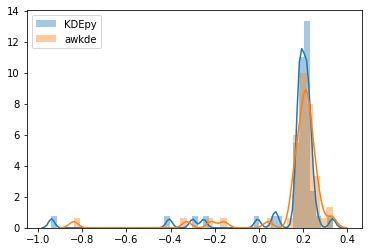

In [55]:
#hide
import matplotlib.pyplot as plt
#sns.distplot((np.array(tree_kde[0]) - np.array(entropies))/np.array(entropies))
sns.distplot((np.array(fft_kde[0]) - np.array(entropies))/np.array(entropies), label = 'KDEpy')
sns.distplot((np.array(adapatative_kde[0]) - np.array(entropies))/np.array(entropies), label = 'awkde')
plt.legend()
np.array(entropies).mean()


Text(0, 0.5, 'log(time in seconds)')

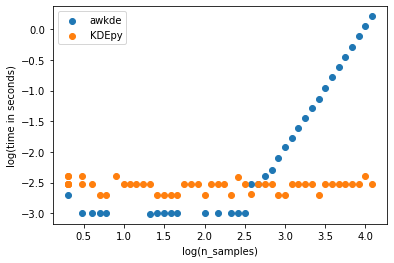

In [56]:
#hide
#sns.distplot(np.log10(np.array(tree_kde[1])[np.array(tree_kde[1])>0]))
plt.scatter(np.log10(np.array(n_samples_list))[np.array(adapatative_kde[1])>0],np.log10(np.array(adapatative_kde[1])[np.array(adapatative_kde[1])>0]), label = 'awkde')
plt.scatter(np.log10(np.array(n_samples_list))[np.array(fft_kde[1])>0],np.log10(np.array(fft_kde[1])[np.array(fft_kde[1])>0]), label = 'KDEpy')
plt.legend()
plt.xlabel('log(n_samples)')
plt.ylabel('log(time in seconds)')
#sns.distplot(np.log10(np.array(fft_kde[1])[np.array(fft_kde[1])>0]))


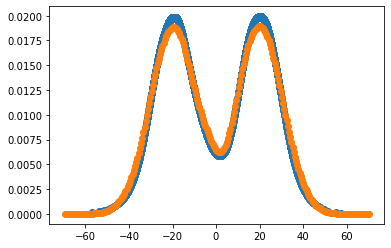

In [57]:
#hide
if np.array(samples).shape[1] == 1:
    #plt.scatter(samples[:,0],dist.pdf(samples))
    #plt.scatter(samples[:,0],kde.evaluate(samples), color = 'r')
    plt.scatter(samples[:,0],g.predict(samples))
    plt.scatter(*kde.evaluate(256))

# Export -

In [66]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.
Converted 04_metrics.ipynb.
Converted 05_neighbors.ipynb.
Converted 06_kde_baesyan_nets.ipynb.
Converted index.ipynb.
